## Natural Language Processing on TED Talk Data

We will be preprocessing, performing some exploratory data analysis and topic modeling on English-language transcripts from TED Talks held between 2006 and 2020! The data can be found at https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(rc = {'figure.figsize':(10,8)})

In [12]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

In [13]:
df = pd.read_csv("/Users/andre/OneDrive/Documents/ted_talks/2020-05-01/ted_talks_en.csv")
df.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


## Data Cleaning and Feature Engineering

We first extract the year from the `recorded_date` variable.

In [14]:
df['published_year'] = df.published_date.apply(lambda x: x[:4])
df['published_year']

0       2006
1       2006
2       2006
3       2006
4       2006
        ... 
4000    2020
4001    2020
4002    2020
4003    2020
4004    2020
Name: published_year, Length: 4005, dtype: object

### Getting occupations

The `occupations` variable comes in the form of a dictionary, which was converted to the string data type when read from the `csv` file. Here we extract the occupation(s).

In [15]:
df['occupations'] = df.occupations.fillna("[Unknown]")
df['occupations_fixed'] = df.occupations.apply(lambda x: re.findall("\[(.*)\]", x))

In [16]:
df['occupations_fixed'] = df.occupations_fixed.apply(lambda x: x[0].replace("'",''))

In [17]:
df['occupations_fixed']

0                           climate advocate
1       global health expert; data visionary
2                       technology columnist
3         activist for environmental justice
4                           author, educator
                        ...                 
4000                         health activist
4001                                 Unknown
4002                          law researcher
4003                                 Unknown
4004                                 Unknown
Name: occupations_fixed, Length: 4005, dtype: object

### Removing numbers

We want to remove numbers from the description and transcripts of the TED Talks to have the model give better results.

In [18]:
df['description_wo_nums'] = df['description'].apply(lambda x: re.sub(r'[0-9]','',x))
df['transcript_wo_nums'] = df['transcript'].apply(lambda x: re.sub(r'[0-9]','',x))
df['transcript_wo_nums']

0       Thank you so much, Chris. And it's truly a gre...
1       About  years ago, I took on the task to teach ...
2       (Music: "The Sound of Silence," Simon & Garfun...
3       If you're here today — and I'm very happy that...
4       Good morning. How are you? (Audience) Good. It...
                              ...                        
4000    "I'm , and I want to go home." "My name is Bet...
4001    In , psychologists Alfred Binet and Théodore S...
4002    Picture yourself driving down the road tomorro...
4003    In early , Sojourner Truth approached the Gran...
4004    Can you guess what you’re looking at? Is it a ...
Name: transcript_wo_nums, Length: 4005, dtype: object

### Removing punctuation

We remove punctuation so that the text vectorizers don't double count words, for example, "cat" and "cat,".

In [19]:
import string

def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation + "—"]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
    
df['desc_wo_nums_punct'] = df['description_wo_nums'].apply(remove_punctuation)
df['trans_wo_nums_punct'] = df['transcript_wo_nums'].apply(remove_punctuation)
df['trans_wo_nums_punct']

0       Thank you so much Chris And its truly a great ...
1       About  years ago I took on the task to teach g...
2       Music The Sound of Silence Simon  Garfunkel He...
3       If youre here today  and Im very happy that yo...
4       Good morning How are you Audience Good Its bee...
                              ...                        
4000    Im  and I want to go home My name is Beth Im h...
4001    In  psychologists Alfred Binet and Théodore Si...
4002    Picture yourself driving down the road tomorro...
4003    In early  Sojourner Truth approached the Grand...
4004    Can you guess what you’re looking at Is it a f...
Name: trans_wo_nums_punct, Length: 4005, dtype: object

### Tokenizing

Tokenizing text refers to splitting it into an array with each word as an element. This will allow us to perform exploatory analysis on word frequencies later on. At the same time, we also convert all words to lowercase to prevent double counting words.

In [20]:
from nltk.tokenize import word_tokenize

word_tokenize("When I grow up I want to be a data scientist!")

['When',
 'I',
 'grow',
 'up',
 'I',
 'want',
 'to',
 'be',
 'a',
 'data',
 'scientist',
 '!']

In [21]:
df['desc_wo_nums_punct_token'] = df['desc_wo_nums_punct'].apply(lambda x: word_tokenize(x.lower()))
df['trans_wo_nums_punct_token'] = df['trans_wo_nums_punct'].apply(lambda x: word_tokenize(x.lower()))
df['trans_wo_nums_punct_token']

0       [thank, you, so, much, chris, and, its, truly,...
1       [about, years, ago, i, took, on, the, task, to...
2       [music, the, sound, of, silence, simon, garfun...
3       [if, youre, here, today, and, im, very, happy,...
4       [good, morning, how, are, you, audience, good,...
                              ...                        
4000    [im, and, i, want, to, go, home, my, name, is,...
4001    [in, psychologists, alfred, binet, and, théodo...
4002    [picture, yourself, driving, down, the, road, ...
4003    [in, early, sojourner, truth, approached, the,...
4004    [can, you, guess, what, you, ’, re, looking, a...
Name: trans_wo_nums_punct_token, Length: 4005, dtype: object

### Remove stopwords

There are unimportant words that do not significantly contribute to the model, and so we will filter them out from the texts before processing them. This will ensure that the process does not assign importance to words that appear often but do not mean much in the context of the text.

Upon reading through some of the transcripts, there also seem to be places where the audience laughs after the speaker cracks a joke or applauses at the end or after something incredible happens. Those moments are recorded as "(applause)" and "(laughter)" as seen in the example shown below.

In [22]:
df.transcript[2062][:2004]

'A few years ago, I got one of those spam emails. And it managed to get through my spam filter. I\'m not quite sure how, but it turned up in my inbox, and it was from a guy called Solomon Odonkoh. (Laughter) I know. (Laughter) It went like this: it said, "Hello James Veitch, I have an interesting business proposal I want to share with you, Solomon." Now, my hand was kind of hovering on the delete button, right? I was looking at my phone. I thought, I could just delete this. Or I could do what I think we\'ve all always wanted to do. (Laughter) And I said, "Solomon, Your email intrigues me." (Laughter) (Applause) And the game was afoot. He said, "Dear James Veitch, We shall be shipping Gold to you." (Laughter) "You will earn 10% of any gold you distributes." (Laughter) So I knew I was dealing with a professional. (Laughter) I said, "How much is it worth?" He said, "We will start with smaller quantity," — I was like, aww — and then he said, "of 25 kgs. (Laughter) The worth should be about

We remove the words "laughter" and "applause" from the texts. All vowels except "u" seem to be included in `nltk`'s list of stopwords, so I chose to include it to make things more consistent.

In [23]:
from nltk.corpus import stopwords

stops = stopwords.words('english')
stops.append('u')
stops.append('laughter')
stops.append('applause')
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
def remove_stopwords(text):
    text=[word for word in text if word not in stops]
    return text
    
df['desc_wo_nums_punct_token_stops'] = df['desc_wo_nums_punct_token'].apply(remove_stopwords)
df['trans_wo_nums_punct_token_stops'] = df['trans_wo_nums_punct_token'].apply(remove_stopwords)
df['trans_wo_nums_punct_token_stops']

0       [thank, much, chris, truly, great, honor, oppo...
1       [years, ago, took, task, teach, global, develo...
2       [music, sound, silence, simon, garfunkel, hell...
3       [youre, today, im, happy, youve, heard, sustai...
4       [good, morning, audience, good, great, hasnt, ...
                              ...                        
4000    [im, want, go, home, name, beth, im, tell, ive...
4001    [psychologists, alfred, binet, théodore, simon...
4002    [picture, driving, road, tomorrow, heading, so...
4003    [early, sojourner, truth, approached, grand, j...
4004    [guess, ’, looking, fuzzy, sock, overripe, ban...
Name: trans_wo_nums_punct_token_stops, Length: 4005, dtype: object

### Removing initials and other words two letters or less

Sometimes, transcripts may contain the first and last initials of multiple speakers that will not contribute to the models. To make the data cleaner, I decided to remove any other words that are two letters long.

In [25]:
text = "I dont care I love CJ and AB"

re.findall(r"\b\w{1,2}\b",text)

['I', 'I', 'CJ', 'AB']

In [26]:
def remove_shorts(words: list):
    shorts = re.findall(r"\b\w{1,2}\b",' '.join(words))
    return [word for word in words if word not in shorts]

df['trans_wo_nums_punct_token_stops_shorts'] = df['trans_wo_nums_punct_token_stops'].apply(remove_shorts)
df['desc_wo_nums_punct_token_stops_shorts'] = df['desc_wo_nums_punct_token_stops'].apply(remove_shorts)

### Lemmatizing

Lemmatizing refers to grouping together the inflected forms of a word so they can be analysed as a single item, identified by its dictionary form. This is not to be confused with stemming, which simply takes the root word of a group of words. The latter is a faster process, but lemmatizing is known to help NLP models give more accurate results.

In [27]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
words = ["believe","believing","believed","believes"]

for word in words:
    print(ps.stem(word))

believ
believ
believ
believ


In [28]:
from nltk.stem.wordnet import WordNetLemmatizer

words = ["believe","believing","believed","believes"]

wn = WordNetLemmatizer()

for word in words:
    print(wn.lemmatize(word))

believe
believing
believed
belief


In [29]:
df['desc_wo_nums_punct_token_stops_shorts_lem'] = df['desc_wo_nums_punct_token_stops_shorts'].apply(
    lambda x: [wn.lemmatize(word) for word in x]
)
df['trans_wo_nums_punct_token_stops_shorts_lem'] = df['trans_wo_nums_punct_token_stops_shorts'].apply(
    lambda x: [wn.lemmatize(word) for word in x]
)
df.trans_wo_nums_punct_token_stops_shorts_lem

0       [thank, much, chris, truly, great, honor, oppo...
1       [year, ago, took, task, teach, global, develop...
2       [music, sound, silence, simon, garfunkel, hell...
3       [youre, today, happy, youve, heard, sustainabl...
4       [good, morning, audience, good, great, hasnt, ...
                              ...                        
4000    [want, home, name, beth, tell, ive, run, away,...
4001    [psychologist, alfred, binet, théodore, simon,...
4002    [picture, driving, road, tomorrow, heading, so...
4003    [early, sojourner, truth, approached, grand, j...
4004    [guess, ’, looking, fuzzy, sock, overripe, ban...
Name: trans_wo_nums_punct_token_stops_shorts_lem, Length: 4005, dtype: object

## Exploratory Data Analysis

We would like to perform some exploratory analysis on the data we have. Below are some possible prompts or questions we could answer.

+ how many talks per year?
+ word frequencies from transcripts of certain occuptations?
+ average number of views per occupation or year
+ common topics
+ which topics get the most views



Text(0, 0.5, 'Number of TED Talks')

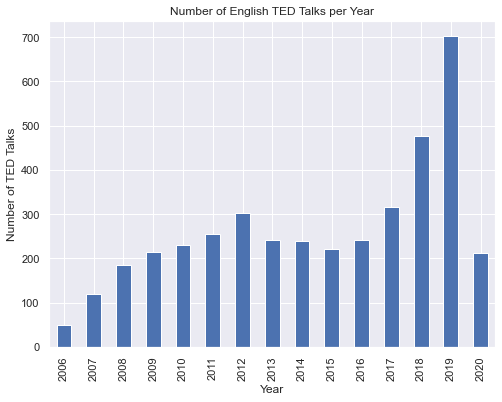

In [19]:
plt.figure(figsize=(8,6))
df['published_year'].value_counts().sort_index().plot.bar()
plt.title("Number of English TED Talks per Year")
plt.xlabel("Year")
plt.ylabel("Number of TED Talks")

Text(0, 0.5, 'Average number of views (millions)')

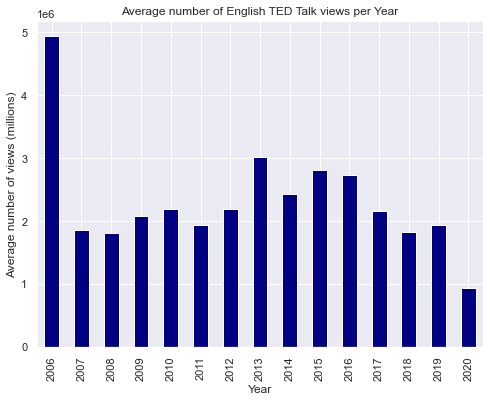

In [175]:
plt.figure(figsize=(8,6))
df.groupby('published_year')['views'].mean().plot.bar(color="navy")
plt.title("Average number of English TED Talk views per Year")
plt.xlabel("Year")
plt.ylabel("Average number of views (millions)")

### Word frequencies of descriptions

In [21]:
allwords_desc = df.desc_wo_nums_punct_token_stops_shorts_lem.sum()

Text(0.5, 1.0, 'Frequency of 20 Most Common Words in TED Talk Descriptions')

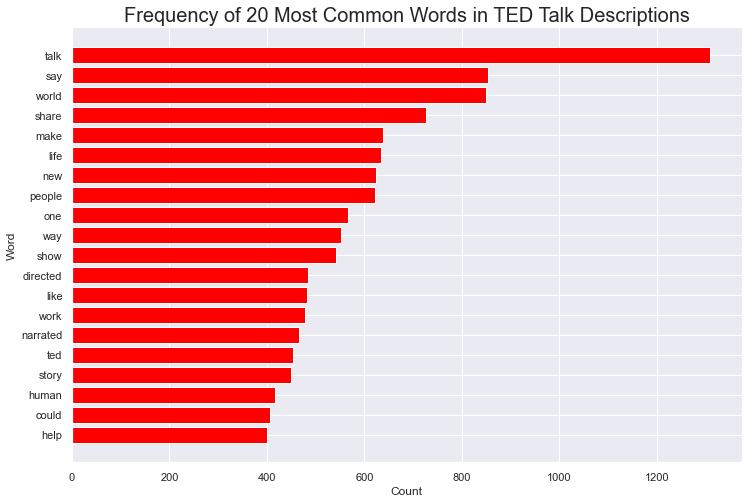

In [174]:
word_freqs = nltk.FreqDist(allwords_desc).most_common(20)
word_freqs.sort(key=lambda t: t[1])
x, y = zip(*word_freqs)

plt.figure(figsize=(12,8))
plt.barh(x,y,color="red")
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Frequency of 20 Most Common Words in TED Talk Descriptions",fontsize=20)

### Word cloud

In [23]:
df.description[82]

"Architect Thom Mayne has never been one to take the easy option, and this whistle-stop tour of the buildings he's created makes you glad for it. These are big ideas cast in material form."

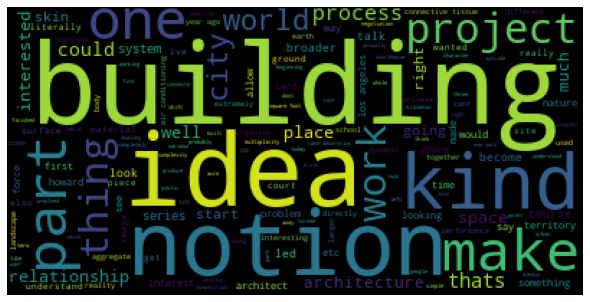

In [24]:
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stops).generate(' '.join(df.trans_wo_nums_punct_token_stops_shorts_lem[82]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Word Frequencies by Occupation

In [25]:
df.occupations_fixed.value_counts()[:25]

Unknown                522
writer                  53
journalist              47
entrepreneur            42
artist                  41
architect               38
designer                37
neuroscientist          32
psychologist            31
educator                29
inventor                28
economist               26
author                  25
photographer            25
physicist               24
roboticist              21
filmmaker               20
philosopher             17
marine biologist        16
technologist            16
producer                15
activist                15
biologist               15
social entrepreneur     12
astronomer              11
Name: occupations_fixed, dtype: int64

In [111]:
def plot_word_freqs(occupation, num_words):
    allwords = df[df.occupations_fixed==occupation].trans_wo_nums_punct_token_stops_shorts_lem.sum()
    word_freqs = nltk.FreqDist(allwords).most_common(num_words)
    word_freqs.sort(key=lambda t: t[1])
    x, y = zip(*word_freqs)
    
    plt.figure(figsize=(12,8))
    plt.barh(x,y)
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.title("Frequency of 20 Most Common Words in TED Talk " + occupation + "s",fontsize=20)

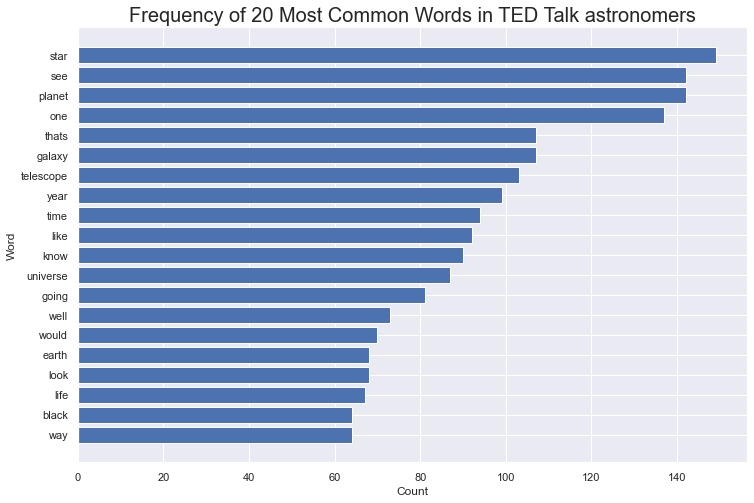

In [112]:
plot_word_freqs("astronomer",20)

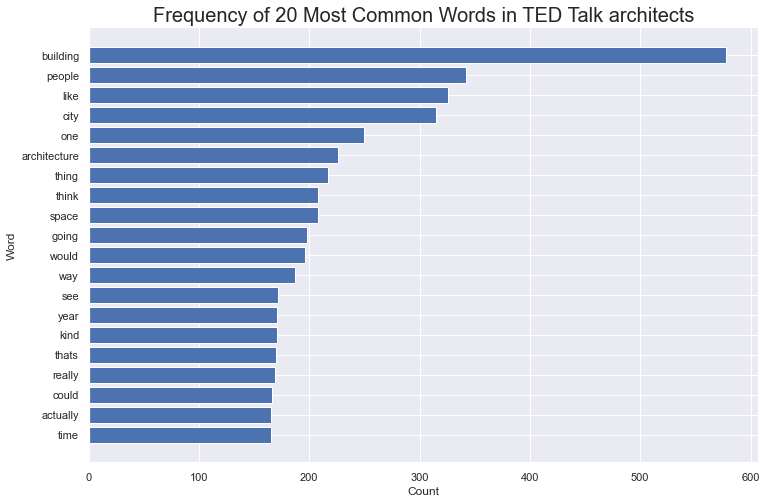

In [28]:
plot_word_freqs("architect",20)

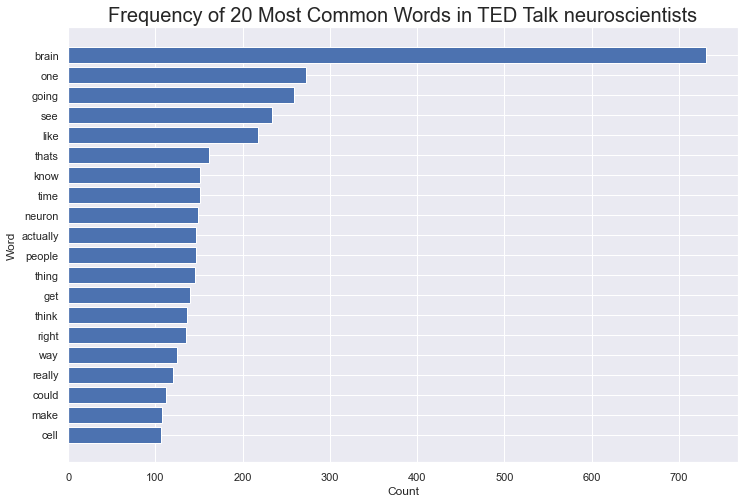

In [29]:
plot_word_freqs("neuroscientist",20)

### Bigram frequencies

Instead of one word, we group two words together!

Text(0.5, 1.0, 'Frequency of 20 Most Common Word Pairs in TED Talk Descriptions')

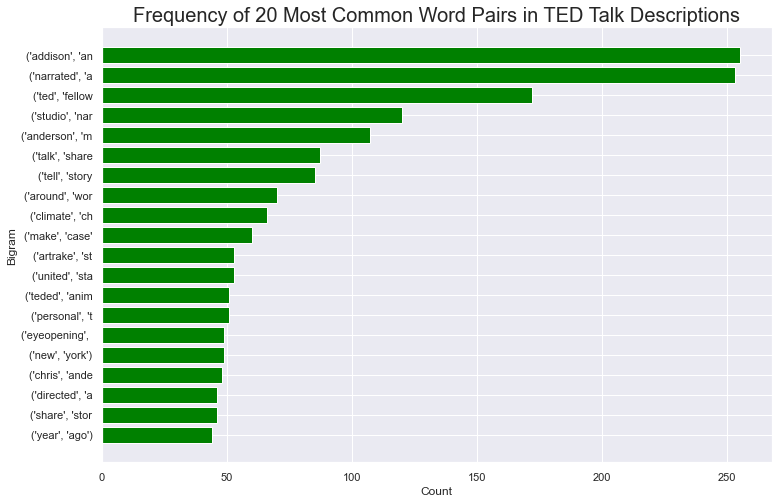

In [172]:
bigram_text = nltk.bigrams(allwords_desc)
bigram_freqs = nltk.FreqDist(bigram_text).most_common(20)
bigram_freqs.sort(key=lambda t: t[1])
x, y = zip(*bigram_freqs)
x = np.apply_along_axis(lambda i: str(tuple(i)), 1, np.array(x))

plt.figure(figsize=(12,8))
plt.barh(x,y,color="green")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.title("Frequency of 20 Most Common Word Pairs in TED Talk Descriptions",fontsize=20)

In [161]:
def plot_bigram_freqs(occupation, num_words):
    allwords = df[df.occupations_fixed==occupation].trans_wo_nums_punct_token_stops_shorts_lem.sum()
    bigram_text = nltk.bigrams(allwords)
    bigram_freqs = nltk.FreqDist(bigram_text).most_common(20)
    bigram_freqs.sort(key=lambda t: t[1])
    x, y = zip(*bigram_freqs)
    x = np.apply_along_axis(lambda i: str(tuple(i)), 1, np.array(x))

    plt.figure(figsize=(12,8))
    plt.barh(x,y,color="orange")
    plt.xlabel("Count")
    plt.ylabel("Bigram")
    plt.title("Frequency of 20 Most Common Word Pairs in TED Talk " + occupation + "s",fontsize=20)

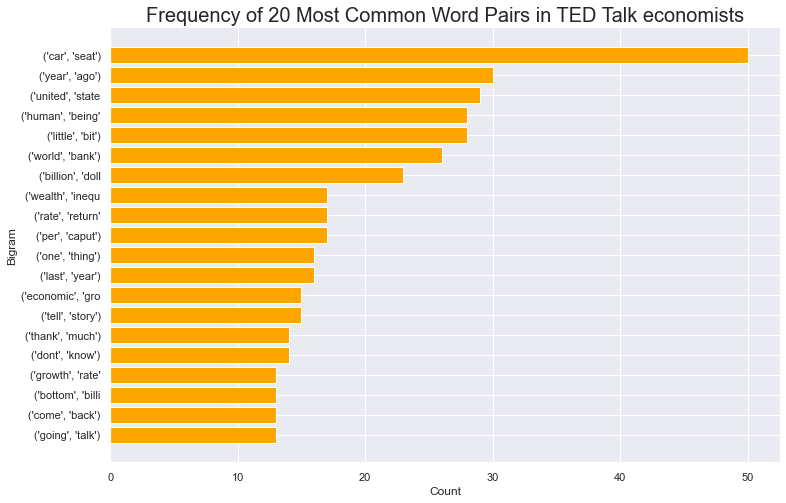

In [167]:
plot_bigram_freqs("economist",20)

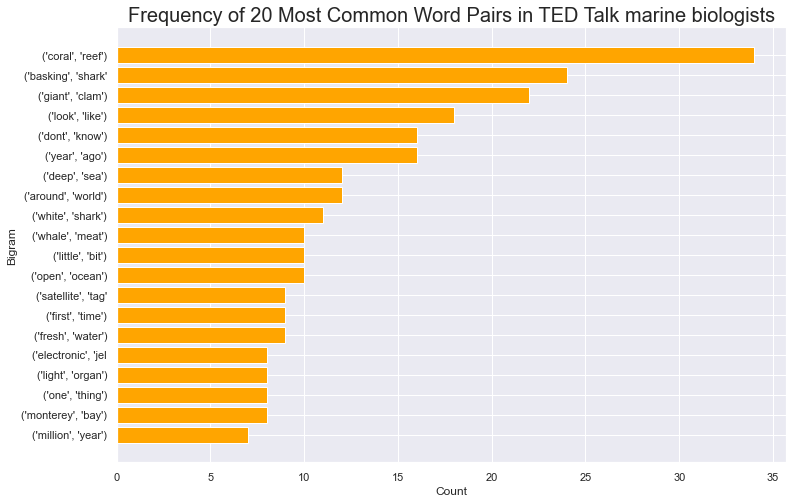

In [171]:
plot_bigram_freqs("marine biologist",20)

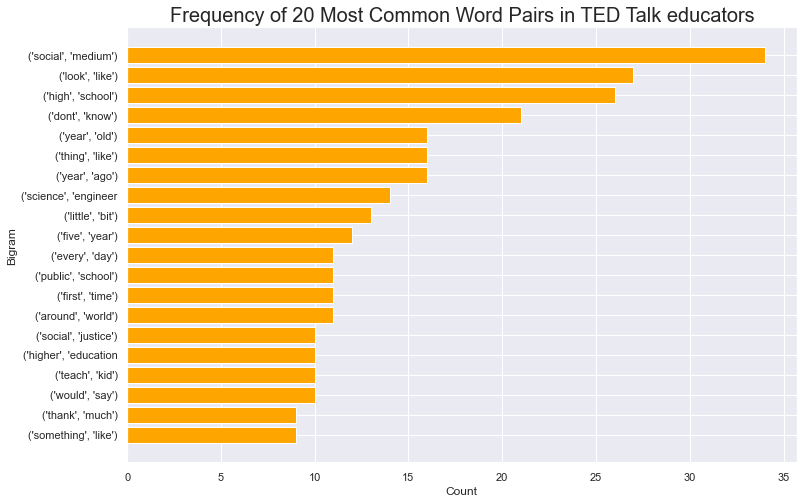

In [166]:
plot_bigram_freqs("educator",20)

## Polarity and Subjectivity

Let's briefly examine the overall polarity and subjectivity of the transcripts using NLTK's TextBlob. The polarity score is a float within the range [-1.0, 1.0], where -1 is most negative and 1 is most positive. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [30]:
from textblob import TextBlob

text = ' '.join(df['trans_wo_nums_punct_token_stops_shorts_lem'][785])
b1 = TextBlob(text)
b1.sentiment

Sentiment(polarity=0.09864951714951717, subjectivity=0.40664454434454445)

In [31]:
df['trans_polarity'] = df['trans_wo_nums_punct_token_stops_shorts_lem'].apply(
    lambda x: TextBlob(' '.join(x)).sentiment.polarity
)
df['trans_subjectivity'] = df['trans_wo_nums_punct_token_stops_shorts_lem'].apply(
    lambda x: TextBlob(' '.join(x)).sentiment.subjectivity
)
df.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,...,desc_wo_nums_punct_token,trans_wo_nums_punct_token,desc_wo_nums_punct_token_stops,trans_wo_nums_punct_token_stops,trans_wo_nums_punct_token_stops_shorts,desc_wo_nums_punct_token_stops_shorts,desc_wo_nums_punct_token_stops_shorts_lem,trans_wo_nums_punct_token_stops_shorts_lem,trans_polarity,trans_subjectivity
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,...,"[with, the, same, humor, and, humanity, he, ex...","[thank, you, so, much, chris, and, its, truly,...","[humor, humanity, exuded, inconvenient, truth,...","[thank, much, chris, truly, great, honor, oppo...","[thank, much, chris, truly, great, honor, oppo...","[humor, humanity, exuded, inconvenient, truth,...","[humor, humanity, exuded, inconvenient, truth,...","[thank, much, chris, truly, great, honor, oppo...",0.118224,0.422749
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,...,"[youve, never, seen, data, presented, like, th...","[about, years, ago, i, took, on, the, task, to...","[youve, never, seen, data, presented, like, dr...","[years, ago, took, task, teach, global, develo...","[years, ago, took, task, teach, global, develo...","[youve, never, seen, data, presented, like, dr...","[youve, never, seen, data, presented, like, dr...","[year, ago, took, task, teach, global, develop...",0.089149,0.455971
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,...,"[new, york, times, columnist, david, pogue, ta...","[music, the, sound, of, silence, simon, garfun...","[new, york, times, columnist, david, pogue, ta...","[music, sound, silence, simon, garfunkel, hell...","[music, sound, silence, simon, garfunkel, hell...","[new, york, times, columnist, david, pogue, ta...","[new, york, time, columnist, david, pogue, tak...","[music, sound, silence, simon, garfunkel, hell...",0.122056,0.482848
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,...,"[in, an, emotionally, charged, talk, macarthur...","[if, youre, here, today, and, im, very, happy,...","[emotionally, charged, talk, macarthurwinning,...","[youre, today, im, happy, youve, heard, sustai...","[youre, today, happy, youve, heard, sustainabl...","[emotionally, charged, talk, macarthurwinning,...","[emotionally, charged, talk, macarthurwinning,...","[youre, today, happy, youve, heard, sustainabl...",0.049556,0.431142
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,...,"[sir, ken, robinson, makes, an, entertaining, ...","[good, morning, how, are, you, audience, good,...","[sir, ken, robinson, makes, entertaining, prof...","[good, morning, audience, good, great, hasnt, ...","[good, morning, audience, good, great, hasnt, ...","[sir, ken, robinson, makes, entertaining, prof...","[sir, ken, robinson, make, entertaining, profo...","[good, morning, audience, good, great, hasnt, ...",0.137153,0.461791


<AxesSubplot:ylabel='Frequency'>

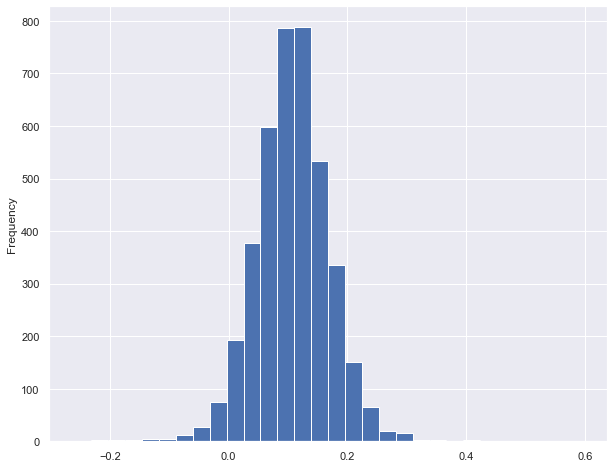

In [32]:
df.trans_polarity.plot.hist(bins=30)

Polarity of the TED Talks overall seem to be relatively positive, centered around .1 with a few slightly negative ones.

<AxesSubplot:ylabel='Frequency'>

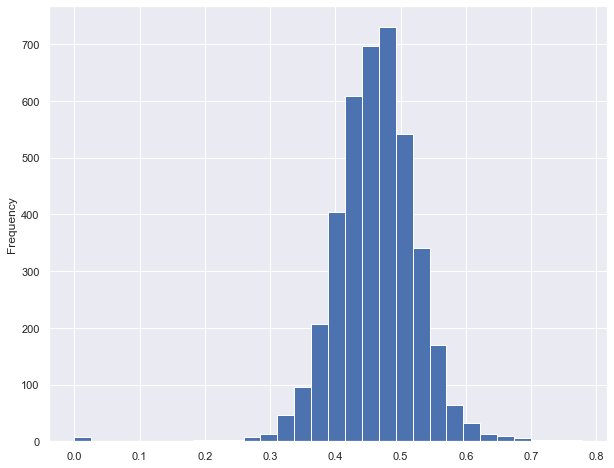

In [33]:
df.trans_subjectivity.plot.hist(bins=30)

Subjectivity overall seems quite high on the subjective side, suggesting a majority of TED Talks are very opinionated in which the speakers primarily convey their own thoughts on their respective topics.

## Topic Modeling

Manually reading through each TED Talk and determining ..., So, we are going to rely on an algorithm to do the job for us! We will focus on non-negative matrix factorization (NMF). 

Before we implement, NMF, we must first convert our 4,005 transcripts to one big sparse matrix of term frequency-inverse document frequency (*tf-idf*) scores. The *tf-idf* of a word in a document quantifies how important it is in the context of the document or corpus. The statistic is calculated using the following formula.

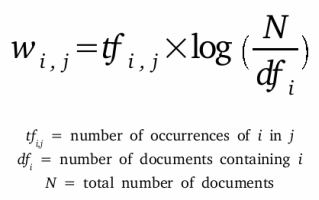

The subscript *i* represents the word in question, while *j* represents the document number.

In [34]:
df['trans_str'] = df['trans_wo_nums_punct_token_stops_shorts_lem'].apply(lambda x: ' '.join(x))

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['trans_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,abandoned,ability,able,abroad,absence,absolute,absolutely,absorb,abstract,abundance,...,youngest,youre,youth,youtube,youve,zealand,zero,zone,zoo,zoom
0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,...,0.0000,0.025030,0.0,0.0,0.017638,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.016000,0.0,0.0,0.018395,0.0000,0.000000,0.000000,0.00000,...,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0429,0.000000,0.000000,0.00000,...,0.0000,0.069984,0.0,0.0,0.032877,0.0,0.0,0.0,0.0,0.0
3,0.04529,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.046361,0.000000,0.02405,...,0.0000,0.022153,0.0,0.0,0.020814,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.028590,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.023915,0.00000,...,0.0000,0.068976,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,0.00000,0.000000,0.014571,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,...,0.0000,0.038473,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4001,0.00000,0.053539,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,...,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4002,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,...,0.0000,0.018136,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4003,0.00000,0.000000,0.022980,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,...,0.0655,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [35]:
tfidf.shape

(4005, 5000)

Now how does NMF work? NMF takes our large *tf-idf* matrix of dimensions 4005 x 5000 we will denote as $\textbf{A}$ and factors it into two matrices of smaller dimensions: feature matrix $\textbf{W}$ (4005 x $n$) and coefficient matrix $\textbf{H}$ ($n$ x 5000) containing the *tf-idf* weights associated with $\textbf{W}$. The variable $n$ represents the number of topics we would like to predict. Both of these matrices contain strictly non-negative elements. NMF performs dimensionality reduction and feature extraction; it assumes that there are hidden features inside $\textbf{A}$, which contains weights associated with $\textbf{W}$.

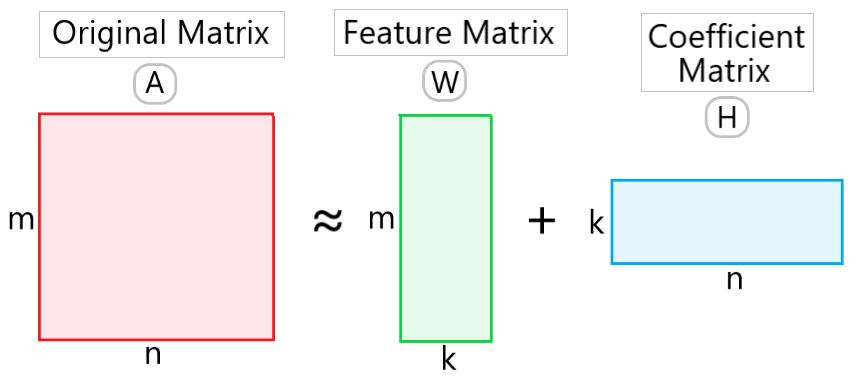

After plugging in a few values, I decided to extract 11 topics from our dataset, though there is a more formal process of tuning the number of topics using a metric called coherence scores. We use `sci-kit learn`'s NMF to fit the model onto our matrix with Nonnegative Double Singular Value Decomposition (NNDSVD) initialization.

In [36]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=11, random_state=0, init='nndsvd',max_iter=1000).fit(tfidf)

In [37]:
no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
thing going know people like think really get thats dont
Topic 1:
universe star galaxy light planet earth space particle telescope energy
Topic 2:
people country world government africa percent company year need dollar
Topic 3:
cell cancer patient drug disease blood body tumor health dna
Topic 4:
water ocean fish animal sea plant specie food earth climate
Topic 5:
music sound song play musical musician singing orchestra instrument guitar
Topic 6:
brain neuron memory sleep body signal behavior disorder activity stress
Topic 7:
city building design space architecture people community urban new street
Topic 8:
woman men girl sex gender female male sexual black boy
Topic 9:
robot computer data technology machine video information actually human like
Topic 10:
child school life kid story family said one day would


We can easily make out the overall topics based on the top 10 words of each component of the model. This doesn't seem to be the case for topic 0 however, as its words are a lot more vague. For now I decided to generalize its words as "people."

0. people
1. astronomy
2. politics, economics, poverty
3. molecular biology and disease
4. ecology
5. music
6. neuroscience and psychology
7. architecture and urban planning
8. gender and ethnic studies
9. technology
10. family and education

We can then map each document to their predicted topics.

In [38]:
nmf_topic_values = nmf.transform(tfidf)
df['nmf_topics'] = nmf_topic_values.argmax(axis=1)

In [39]:
nmf_remap = {0: 'People', 1: 'Astronomy', 2: 'Politics and Economics', 3: 'Molecular Biology and Disease', 
             4: 'Ecology', 5: 'Music', 6: 'Neuroscience and Psychology', 7: 'Architecture and Urban Development', 
             8: 'Gender and Ethnic Studies', 9: 'Technology', 10: 'Family and Education'}

df['nmf_topics'] = df['nmf_topics'].map(nmf_remap)
df.nmf_topics

0                   Politics and Economics
1                   Politics and Economics
2                                   People
3       Architecture and Urban Development
4                     Family and Education
                       ...                
4000                Politics and Economics
4001                Politics and Economics
4002                Politics and Economics
4003                  Family and Education
4004                               Ecology
Name: nmf_topics, Length: 4005, dtype: object

In [181]:
df[df.nmf_topics=="Neuroscience and Psychology"][["title","description","occupations_fixed"]]

,title,description,occupations_fixed
22,"Why we love, why we cheat",Anthropologist Helen Fisher takes on a tricky ...,"anthropologist, expert on love"
39,My wish: Three unusual medical inventions,"Accepting his 2005 TED Prize, inventor Robert ...",biomedical inventor
104,How brain science will change computing,Treo creator Jeff Hawkins urges us to take a n...,"computer designer, brain researcher"
116,Dangerous memes,"Starting with the simple tale of an ant, philo...","philosopher, cognitive scientist"
150,3 clues to understanding your brain,Vilayanur Ramachandran tells us what brain dam...,brain expert
...,...,...,...
3921,What is dyslexia?,"Dyslexia affects up to 1 in 5 people, but the ...",Unknown
3932,What investigating neural pathways can reveal ...,Neuroscientist Kay M. Tye investigates how you...,neuroscientist
3938,How menopause affects the brain,Many of the symptoms of menopause -- hot flash...,neuroscientist
3962,What is schizophrenia?,Schizophrenia was first identified more than a...,Unknown


In [182]:
df[df.nmf_topics=="Technology"][["title","description","occupations_fixed"]]

,title,description,occupations_fixed
13,The radical promise of the multi-touch interface,"Jeff Han shows off a cheap, scalable multi-tou...",human-computer interface designer
19,The birth of the open-source learning revolution,"In 2006, open-learning visionary Richard Baran...",education visionary
43,How technology evolves,"Tech enthusiast Kevin Kelly asks ""What does te...",digital visionary
44,The accelerating power of technology,"Inventor, entrepreneur and visionary Ray Kurzw...","inventor, futurist"
58,Everyday inventions,Inventor and MacArthur fellow Saul Griffith sh...,inventor
...,...,...,...
3933,How one woman put man on the moon,The Apollo 11 moon landing was about the astro...,Unknown
3951,A fascinating time capsule of human feelings t...,How comfortable are you with robots taking ove...,tech strategist
3958,A camera that can see around corners,"To work safely, self-driving cars must avoid o...",electrical engineer
3987,"How to spark your curiosity, scientifically",Curious how stuff works? Do a hands-on experim...,experimental physicist


At a glance, though not perfect, the NMF algorithm seems to have predicted and assigned topics fairly well!

Text(0.5, 1.0, 'Number of TED Talks by Topics Predicted by NMF')

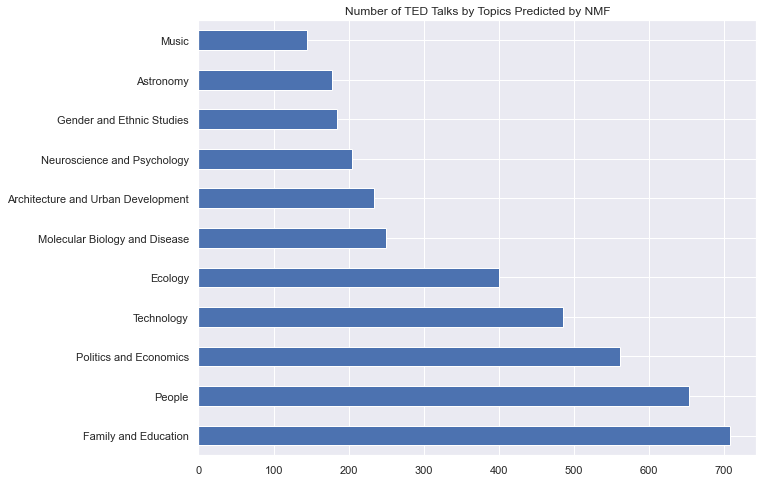

In [40]:
plt.figure(figsize=(10,8))
df.nmf_topics.value_counts().plot.barh()
plt.title("Number of TED Talks by Topics Predicted by NMF")

<AxesSubplot:xlabel='views', ylabel='nmf_topics'>

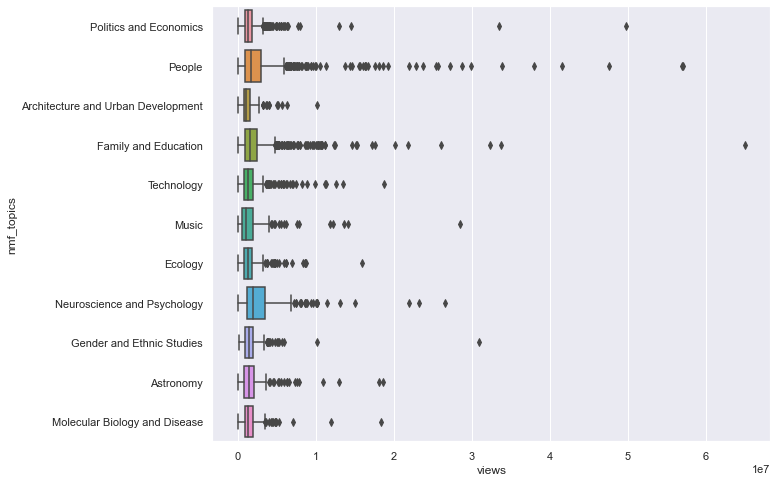

In [41]:
sns.boxplot(data=df,x="views",y="nmf_topics",orient="h")

Text(0.5, 1.0, 'Median Number of Views per NMF Topic')

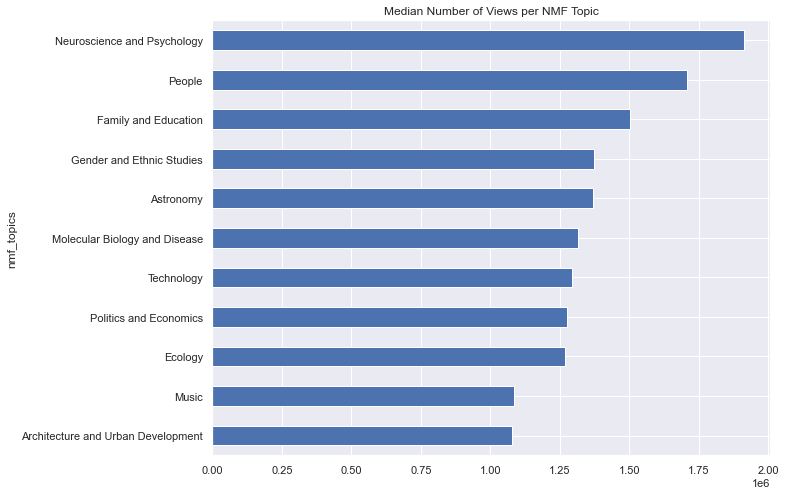

In [42]:
plt.figure(figsize=(10,8))
df.groupby('nmf_topics')['views'].median().sort_values().plot.barh()
plt.title("Median Number of Views per NMF Topic")

### *t*-testing

Is there a significant difference in the mean number of views of TED Talks in the People category and the Family & Education category?

In [44]:
from scipy.stats import ttest_ind

print(df[df.nmf_topics=="People"]['views'].var())
print(df[df.nmf_topics=="Family and Education"]['views'].var())

32147200851032.395
15503295946872.908


The variances are unequal, which violates an assumption of the Student's *t*-test. We can set respective argument equal to False to perform a Welch's *t*-test of unequal variances.

In [45]:
ttest_ind(df[df.nmf_topics=="People"]['views'], 
          df[df.nmf_topics=="Family and Education"]['views'], 
          equal_var=False, axis=0) 

Ttest_indResult(statistic=2.870419816031585, pvalue=0.004174297189922047)

Based on the test statistic and small p-value of .004, we have strong evidence suggesting that there is a significant difference in average number of views between TED Talks of the "People" topic and Family/Education.

### Residuals

We can gauge how well the NMF model predicted each document's topic by calculating their average residuals. For each document/transcript, we take the Frobenius norm of its *tf-idf* scores in $\textbf{A}$ minus the dot product of the corresponding row of $\textbf{W}$ and $\textbf{H}$.

In [46]:
A = tfidf.toarray()
r = np.zeros(A.shape[0])
W = nmf.fit_transform(A)
H = nmf.components_

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - W[row, :].dot(H))

In [47]:
r

array([0.89772369, 0.85792643, 0.87399273, ..., 0.96197665, 0.95910928,
       0.9514357 ])

Manually calculating the Frobenium norm of matrix difference between $\textbf{A}$ and $\textbf{WH}$:

In [48]:
np.linalg.norm(A-W.dot(H),'fro')

58.285615118291304

In [49]:
nmf.reconstruction_err_

58.285615118291304

In [50]:
df['residuals'] = r

[Text(0.5, 1.0, 'Average Residual per Topic')]

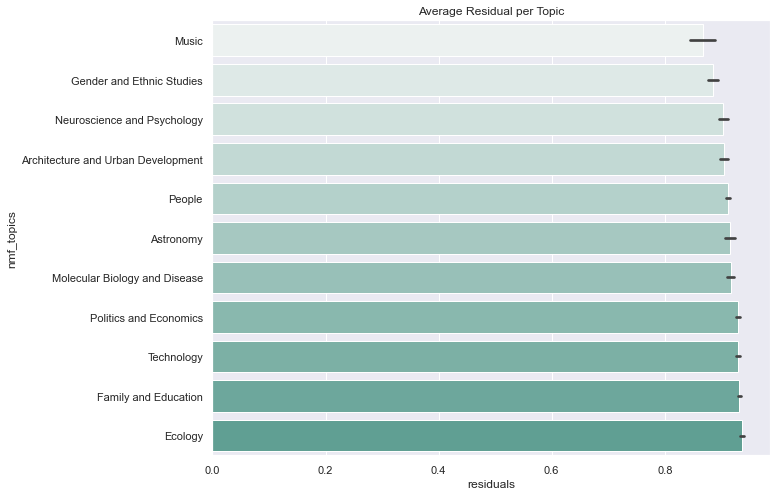

In [51]:
mean_res = df.groupby('nmf_topics')['residuals'].mean().sort_values() 

sns.barplot(data=df,
            x="residuals",
            y="nmf_topics",
            order=mean_res.index,
            orient="h",
            palette="light:#5A9").set(title="Average Residual per Topic")

Our NMF algorithm seems to have predicted the documents with the Music topic the most accurately, followed by Gender and Ethnic studies.

### Latent Dirichlet Allocation

LDA is another topic modeling algorithm. https://www.geeksforgeeks.org/latent-dirichlet-allocation/

In [60]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=11, learning_method='online', max_iter=1000, random_state=0).fit(tfidf)

In [61]:
no_top_words = 10

display_topics(lda_model, tfidf_feature_names, no_top_words)

Topic 0:
people one like thing know going time would year think
Topic 1:
music guitar thank much end start biscuit steady sloth vulture
Topic 2:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 3:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 4:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 5:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 6:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 7:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 8:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 9:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour
Topic 10:
biscuit guitar steady sloth vulture rebel dragonfly mechanical digit pour


Wow. I'm not sure what to say here...it seems that LDA model didn't really know what it was doing with the data. It came up with three topics, yet the words in each have very little to do with each other.

### Latent Semantic Analysis (Truncated Singular Value Decomposition)

In [72]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=11,random_state=0).fit(tfidf)

In [73]:
no_top_words = 10

display_topics(lsa, tfidf_feature_names, no_top_words)

Topic 0:
people one like thing know going think get really time
Topic 1:
woman girl child said people men school family country story
Topic 2:
music brain like thing know sound youre love play said
Topic 3:
brain cell woman cancer patient disease body drug blood health
Topic 4:
music water woman earth ocean planet universe light sea life
Topic 5:
music country city health people government sound patient africa data
Topic 6:
brain woman universe language data image information computer galaxy space
Topic 7:
city building design school kid architecture art child space cell
Topic 8:
brain neuron child ocean water food fish people kid animal
Topic 9:
woman brain robot city men water plant fish girl food
Topic 10:
school kid child student robot teacher education girl learning universe
